<a href="https://colab.research.google.com/github/mermora97/WiDS-Datathon-2024/blob/main/WiDS_Challenge_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries

In [ ]:
!pip install opendatasets

In [ ]:
#Import necessary libraries
import opendatasets as od
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# Importing PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# importing the required function
from scipy.stats import chi2_contingency
from itertools import product
import scipy.stats as ss

# Model training
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/WiDS\ Competition

/content/drive/MyDrive/WiDS Competition


## Support functions

In [ ]:
# Creating metric function
def metrics_score(actual, predicted, pred_labels):
    print(classification_report(actual, predicted))
    print('AUC: ', roc_auc_score(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize = (8, 5))
    sns.heatmap(cm, annot = True, fmt ='.2f', xticklabels = pred_labels, yticklabels = pred_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Divide columns in categorical_columns and numerical_columns
def get_numerical_cols(df):
    return df.select_dtypes('number').columns.tolist()

def get_categorical_cols(df):
    return df.select_dtypes('object').columns.tolist()

# Compare target variable
def compare_DiagPeriodL90D(df,col):
    DiagPeriodL90D_true = df[df['DiagPeriodL90D']==1.0][col].value_counts(normalize=True)*100
    DiagPeriodL90D_false = df[df['DiagPeriodL90D']==0.0][col].value_counts(normalize=True)*100
    print(pd.concat([DiagPeriodL90D_true,DiagPeriodL90D_false],axis=1,keys=["Diagnosis","No Diagnosis"]))

# **Dataset Description**
The **WiDS Datathon 2024** focuses on a prediction task using a roughly 39k record dataset (split into training and test sets) representing patients and their characteristics (age, race, BMI, zip code), their diagnosis and treatment information (breast cancer diagnosis code, metastatic cancer diagnosis code, metastatic cancer treatments, … etc.), their geo (zip-code level) demographic data (income, education, rent, race, poverty, …etc), as well as toxic air quality data (Ozone, PM25 and NO2) that tie health outcomes to environmental conditions. Each row in the data corresponds a single patient and her Diagnosis Period. Your task is to assess whether the likelihood of the patient’s Diagnosis Period being less than 90 days is predictable using these characteristics and information about the patient.




*   DiagPeriodL90D (target variable): Diagnosis Period Less Than 90 Days. This is an indication of whether the cancer was diagnosed within 90 Days.
*   patient_id - Unique identification number of patient
*   patient_race - Asian, African American, Hispanic or Latino, White, Other Race
*   payer_type - payer type at Medicaid, Commercial, Medicare on the metastatic date
*   patient_state - Patient State (e.g. AL, AK, AZ, AR, CA, CO etc…) on the metastatic date
*   patient_zip3 - Patient Zip3 (e.g. 190) on the metastatic date
*   patient_age - Derived from Patient Year of Birth (index year minus year of birth)
*   patient_gender - F, M on the metastatic date
*   bmi - If Available, will show available BMI information (Earliest BMI recording post metastatic date)
*   breast_cancer_diagnosis_code - ICD10 or ICD9 diagnoses code
*   breast_cancer_diagnosis_desc - ICD10 or ICD9 code description. This column is raw text and may require NLP/ processing and cleaning
*   metastatic_cancer_diagnosis_code - ICD10 diagnoses code
*   metastatic_first_novel_treatment - Generic drug name of the first novel treatment (e.g. "Cisplatin") after metastatic diagnosis
*   metastatic_first_novel_treatment_type - Description of Treatment (e.g. Antineoplastic) of first novel treatment after metastatic diagnosis
*   region - Region of patient location
*   division - Division of patient location
*   population - An estimate of the zip code's population.
*   density - The estimated population per square kilometer.
*   age_median - The median age of residents in the zip code.
*   male - The percentage of residents who report being male (e.g. 55.1).
*   female - The percentage of residents who report being female (e.g. 44.9).
*   married - The percentage of residents who report being married (e.g. 44.9).
*   family_size - The average size of resident families (e.g. 3.22).
*   income_household_median - Median household income in USD.
*   income_household_six_figure - Percentage of households that earn at least \$100,000 e.g. 25.3
*   home_ownership - Percentage of households that own (rather than rent) their residence.
*   housing_units - The number of housing units (or households) in the zip code.
*   home_value - The median value of homes that are owned by residents.
*   rent_median - The median rent paid by renters.
*   education_college_or_above - The percentage of residents with at least a 4-year degree.
*   labor_force_participation - The percentage of residents 16 and older in the labor force.
*   unemployment_rate - The percentage of residents unemployed.
*   race_white - The percentage of residents who report their race White.
*   race_black - The percentage of residents who report their race as Black or African American.
*   race_asian - The percentage of residents who report their race as Asian.
*   race_native - The percentage of residents who report their race as American Indian and Alaska Native.
*   race_pacific - The percentage of residents who report their race as Native Hawaiian and Other Pacific Islander.
*   race_other - The percentage of residents who report their race as Some other race.
*   race_multiple - The percentage of residents who report their race as Two or more races.
*   hispanic - The percentage of residents who report being Hispanic. Note: *   Hispanic is considered to be an ethnicity and not a race.
*   age_under_10 - The percentage of residents aged 0-9.
*   age_10_to_19 - The percentage of residents aged 10-19.
*   age_20s - The percentage of residents aged 20-29.
*   age_30s - The percentage of residents aged 30-39.
*   age_40s - The percentage of residents aged 40-49.
*   age_50s - The percentage of residents aged 50-59.
*   age_60s - The percentage of residents aged 60-69.
*   age_70s - The percentage of residents aged 70-79.
*   age_over_80 - The percentage of residents aged over 80.
*   divorced - The percentage of residents divorced.
*   never_married - The percentage of residents never married.
*   widowed - The percentage of residents never widowed.
*   family_dual_income - The percentage of families with dual income earners.
*   income_household_under_5 - The percentage of households with income under \$5,000.
*   income_household_5_to_10 - The percentage of households with income from \\$5,000 - \\$10,000.
*   income_household_10_to_15 - The percentage of households with income from \\$10,000-\\$15,000.
*   income_household_15_to_20 - The percentage of households with income from \\$15,000-\\$20,000.
*   income_household_20_to_25 - The percentage of households with income from \\$20,000-\\$25,000.
*   income_household_25_to_35 - The percentage of households with income from \\$25,000-\\$35,000.
*   income_household_35_to_50 - The percentage of households with income from \\$35,000-\\$50,000.
*   income_household_50_to_75 - The percentage of households with income from \\$50,000-\\$75,000.
*   income_household_75_to_100 - The percentage of households with income from \\$75,000-\\$100,000.
*   income_household_100_to_150 - The percentage of households with income from \\$100,000-\\$150,000.
*   income_household_150_over - The percentage of households with income over \\$150,000.
*   income_individual_median - The median income of individuals in the zip code.
*   poverty - The median value of owner occupied homes.
*   rent_burden - The median rent as a percentage of the median renter's household income.
*   education_less_highschool - The percentage of residents with less than a high school education.
*   education_highschool - The percentage of residents with a high school diploma but no more.
*   education_some_college - The percentage of residents with some college but no more.
*   education_bachelors - The percentage of residents with a bachelor's degree (or equivalent) but no more.
*   education_graduate - The percentage of residents with a graduate degree.
*   education_stem_degree - The percentage of college graduates with a Bachelor's degree or higher in a Science and Engineering (or related) field.
*   self_employed - The percentage of households reporting self-employment income on their 2016 IRS tax return.
*   farmer - The percentage of households reporting farm income on their 2016 IRS tax return.
*   disabled - The percentage of residents who report a disability.
*   limited_english - The percentage of residents who only speak limited English.
*   commute_time - The median commute time of resident workers in minutes.
*   health_uninsured - The percentage of residents who report not having health insurance.
*   veteran - The percentage of residents who are veterans.
*   ozone - Annual Ozone (O3) concentration data at Zip3 level. This data shows how air quality data may impact health.
*   PM25 - Annual Fine Particulate Matter (PM2.5) concentration data at Zip3 level. This data shows how air quality data may impact health.
*   N02 - Annual Nitrogen Dioxide (NO2) concentration data at Zip3 level. This data shows how air quality data may impact health.

# Load data

In [ ]:
#Load data from Kaggle to current directory
od.download(
	"https://www.kaggle.com/competitions/widsdatathon2024-challenge1/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mermora
Your Kaggle Key: ··········


100%|██████████| 5.04M/5.04M [00:00<00:00, 133MB/s]


Extracting archive ./widsdatathon2024-challenge1/widsdatathon2024-challenge1.zip to ./widsdatathon2024-challenge1


In [ ]:
#Load data
train = pd.read_csv('./widsdatathon2024-challenge1/training.csv', index_col='patient_id')
test = pd.read_csv('./widsdatathon2024-challenge1/test.csv', index_col='patient_id')
sub  = pd.read_csv('./widsdatathon2024-challenge1/sample_submission.csv')

states = pd.read_csv('./widsdatathon2024-challenge1/states.csv')
zipcodes = pd.read_csv('./widsdatathon2024-challenge1/zip3.csv')

In [ ]:
#Merge test and training dataset
all_data = pd.concat([train.drop('DiagPeriodL90D',axis= 1),test],axis = 0)

# Exploration

In [ ]:
all_data.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,NaN,NaN,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,NaN,NaN,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,NaN,NaN,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18698 entries, 475714 to 327597
Data columns (total 81 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_race                           9412 non-null   object 
 1   payer_type                             16135 non-null  object 
 2   patient_state                          18626 non-null  object 
 3   patient_zip3                           18698 non-null  int64  
 4   patient_age                            18698 non-null  int64  
 5   patient_gender                         18698 non-null  object 
 6   bmi                                    5718 non-null   float64
 7   breast_cancer_diagnosis_code           18698 non-null  object 
 8   breast_cancer_diagnosis_desc           18698 non-null  object 
 9   metastatic_cancer_diagnosis_code       18698 non-null  object 
 10  metastatic_first_novel_treatment       35 non-null     object 
 

1    62.451573
0    37.548427
Name: DiagPeriodL90D, dtype: float64


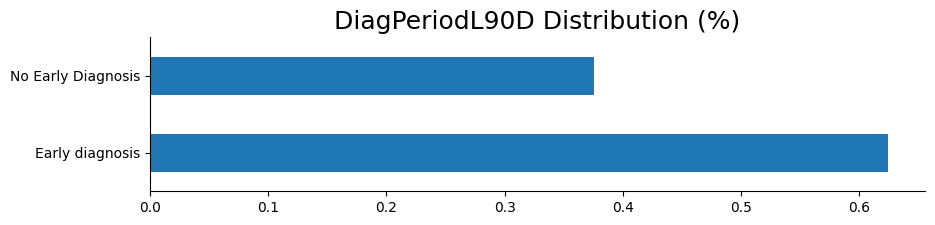

In [ ]:
#First we will look for the distribution of the target variable in the data
print(train.DiagPeriodL90D.value_counts(normalize=True) * 100)

train.DiagPeriodL90D.value_counts(1).plot(kind='barh',figsize=(10, 2)).spines[['top', 'right']].set_visible(False);
plt.title('DiagPeriodL90D Distribution (%)', fontsize=18)
plt.yticks(ticks=[0,1], labels=['Early diagnosis', 'No Early Diagnosis']);

**Observations**
*   There are 12.906 observations and 82 columns in the dataset.
*   Most columns are numeric except 11 columns that are object type.
*   We can convert the zip code to object type too since it has no numeric meaning.
*   The majority of the columns have some missing values. Let's check the number of missing values in each column.
*   The target variable DiagPeriodL90D is unbalanced: 62% seem to be diagnosable in the early 90 days while the remaining 38% are not.




In [ ]:
all_data.patient_zip3 = all_data.patient_zip3.astype("category")

# Missing values

In [ ]:
#Look into patients with many null values
all_data[all_data.isnull().sum(axis=1).sort_values()>30]

<ipython-input-20-623296886c6e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_data[all_data.isnull().sum(axis=1).sort_values()>30]


,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
224030,Black,MEDICAID,FL,332,41,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C7800,NaN,NaN,South,South Atlantic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.544993,8.714016,16.558153


In [ ]:
#Percentage of null values per column
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()*100).sort_values(ascending=False)
pd.options.display.float_format = '{:.2f}'.format
pd.concat([total,percent],axis=1,keys=["Total","%"])

,Total,%
metastatic_first_novel_treatment,18663,99.81
metastatic_first_novel_treatment_type,18663,99.81
bmi,12980,69.42
patient_race,9286,49.66
payer_type,2563,13.71
Division,73,0.39
Region,73,0.39
patient_state,72,0.39
PM25,43,0.23
Ozone,43,0.23


**Observation:**
*   We will delete the columns metastatic_first_novel_treatment and metastatic_first_novel_treatment_type with high percentage of missing values (over 70%)
*   The patients missing state information, miss Region and Division too. We can impute these values using the zip code.
*   We will impute (fill in) the rest of the missing values by using the mode for the categorical variables and median or mean for the numerical ones.

In [ ]:
#Drop variables with null values over 70%
all_data = all_data.drop(percent[percent > 70].index.to_list(),axis=1)

##Impute missing geographic features

In [ ]:
train[train.patient_state.isnull()].head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
994014,White,MEDICARE ADVANTAGE,NaN,973,82,F,NaN,1744,Malignant neoplasm of upper-outer quadrant of ...,C7800,NaN,NaN,NaN,NaN,10110.91,240.58,44.92,9.06,12.10,11.14,11.51,10.54,12.73,18.55,10.74,3.64,52.58,47.42,52.99,13.93,27.53,5.56,2.93,43.35,67230.57,2.67,4.88,3.57,3.29,4.10,8.33,12.17,19.49,13.77,16.81,10.94,27.75,30761.81,70.21,3784.38,306114.43,1061.22,35.09,9.57,27.47,37.75,15.86,9.35,25.21,50.52,51.72,7.70,10.37,3.37,84.57,0.51,1.84,2.19,0.28,3.12,7.50,10.62,19.37,14.59,1.62,26.02,6.65,10.96,36.32,4.74,10.44,0
744114,Hispanic,NaN,NaN,330,83,F,NaN,C50111,Malignant neoplasm of central portion of right...,C773,NaN,NaN,NaN,NaN,34958.92,1716.93,43.38,10.63,11.39,11.20,12.53,13.45,14.94,12.92,8.02,4.93,49.48,50.52,46.28,15.78,31.88,6.06,3.28,52.59,66478.65,3.36,2.97,3.89,3.80,4.21,9.09,12.71,17.46,13.49,14.56,14.46,29.02,32875.39,62.05,12264.35,350955.94,1563.18,39.90,13.20,29.02,27.58,19.00,11.21,30.21,44.04,63.13,5.62,18.44,0.24,61.12,18.48,2.16,0.25,0.04,4.22,13.72,42.83,11.25,13.47,14.07,29.67,15.44,5.09,34.57,7.59,15.27,1
178547,NaN,NaN,NaN,140,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C773,NaN,NaN,NaN,NaN,7373.67,126.46,45.10,10.16,12.00,9.74,11.70,12.05,15.42,15.99,7.67,5.26,51.20,48.80,51.77,13.86,28.41,5.95,2.93,52.50,70151.09,1.81,2.26,3.53,3.91,4.36,9.20,11.46,17.78,16.14,16.32,13.22,29.54,35603.87,81.15,3026.21,167760.45,880.26,29.39,8.94,34.48,31.79,14.36,10.45,24.81,39.84,61.23,4.90,8.97,1.38,91.67,1.84,0.73,1.40,0.01,1.03,3.31,2.75,13.50,9.40,0.75,26.31,4.28,7.56,40.35,6.17,13.79,0
472026,Black,NaN,NaN,916,79,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,C773,NaN,NaN,NaN,NaN,30701.43,3613.50,37.57,8.33,7.47,28.27,16.83,12.06,11.00,8.81,4.33,2.87,49.36,50.64,33.44,10.73,52.74,3.09,3.18,59.65,77386.33,3.29,2.07,4.07,2.94,3.16,6.61,8.69,26.77,11.67,13.40,17.31,30.71,40141.33,28.46,12358.71,833990.00,1790.50,35.70,11.57,12.76,31.26,26.66,17.80,44.46,45.36,75.33,7.20,24.68,0.00,68.17,4.87,6.63,0.49,0.17,10.90,8.77,42.67,8.46,11.27,8.97,30.47,7.21,2.21,43.39,9.49,20.08,1
333582,Hispanic,MEDICAID,NaN,117,66,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C773,NaN,NaN,NaN,NaN,20525.00,1218.84,42.57,10.55,13.89,12.18,10.77,12.53,15.69,12.78,7.24,4.36,49.45,50.55,52.72,9.18,32.18,5.90,3.43,63.46,128029.17,1.91,1.04,1.79,1.76,1.83,3.79,6.47,10.49,10.68,20.66,39.61,60.27,51376.06,84.76,6682.66,517007.18,2060.04,37.35,6.89,22.88,25.22,23.69,21.32,45.01,41.82,65.67,4.63,12.16,0.00,79.48,5.41,5.68,0.19,0.01,3.89,5.34,14.25,9.11,5.21,2.17,33.34,2.76,4.50,39.04,6.21,26.49,1


In [ ]:
train[train.patient_zip3 == 973].head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
994014,White,MEDICARE ADVANTAGE,NaN,973,82,F,NaN,1744,Malignant neoplasm of upper-outer quadrant of ...,C7800,NaN,NaN,NaN,NaN,10110.91,240.58,44.92,9.06,12.10,11.14,11.51,10.54,12.73,18.55,10.74,3.64,52.58,47.42,52.99,13.93,27.53,5.56,2.93,43.35,67230.57,2.67,4.88,3.57,3.29,4.10,8.33,12.17,19.49,13.77,16.81,10.94,27.75,30761.81,70.21,3784.38,306114.43,1061.22,35.09,9.57,27.47,37.75,15.86,9.35,25.21,50.52,51.72,7.70,10.37,3.37,84.57,0.51,1.84,2.19,0.28,3.12,7.50,10.62,19.37,14.59,1.62,26.02,6.65,10.96,36.32,4.74,10.44,0
941363,White,MEDICARE ADVANTAGE,OR,973,72,F,33.63,1749,"Malignant neoplasm of breast (female), unspeci...",C7932,NaN,NaN,West,Pacific,10110.91,240.58,44.92,9.06,12.10,11.14,11.51,10.54,12.73,18.55,10.74,3.64,52.58,47.42,52.99,13.93,27.53,5.56,2.93,43.35,67230.57,2.67,4.88,3.57,3.29,4.10,8.33,12.17,19.49,13.77,16.81,10.94,27.75,30761.81,70.21,3784.38,306114.43,1061.22,35.09,9.57,27.47,37.75,15.86,9.35,25.21,50.52,51.72,7.70,10.37,3.37,84.57,0.51,1.84,2.19,0.28,3.12,7.50,10.62,19.37,14.59,1.62,26.02,6.65,10.96,36.32,4.74,10.44,0
303968,White,MEDICARE ADVANTAGE,OR,973,69,F,33.08,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,West,Pacific,10110.91,240.58,44.92,9.06,12.10,11.14,11.51,10.54,12.73,18.55,10.74,3.64,52.58,47.42,52.99,13.93,27.53,5.56,2.93,43.35,67230.57,2.67,4.88,3.57,3.29,4.10,8.33,12.17,19.49,13.77,16.81,10.94,27.75,30761.81,70.21,3784.38,306114.43,1061.22,35.09,9.57,27.47,37.75,15.86,9.35,25.21,50.52,51.72,7.70,10.37,3.37,84.57,0.51,1.84,2.19,0.28,3.12,7.50,10.62,19.37,14.59,1.62,26.02,6.65,10.96,36.32,4.74,10.44,0
312287,White,MEDICARE ADVANTAGE,OR,973,84,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,C7801,NaN,NaN,West,Pacific,10110.91,240.58,44.92,9.06,12.10,11.14,11.51,10.54,12.73,18.55,10.74,3.64,52.58,47.42,52.99,13.93,27.53,5.56,2.93,43.35,67230.57,2.67,4.88,3.57,3.29,4.10,8.33,12.17,19.49,13.77,16.81,10.94,27.75,30761.81,70.21,3784.38,306114.43,1061.22,35.09,9.57,27.47,37.75,15.86,9.35,25.21,50.52,51.72,7.70,10.37,3.37,84.57,0.51,1.84,2.19,0.28,3.12,7.50,10.62,19.37,14.59,1.62,26.02,6.65,10.96,36.32,4.74,10.44,1
314000,White,MEDICARE ADVANTAGE,OR,973,64,F,33.64,C50919,Malignant neoplasm of unsp site of unspecified...,C779,NaN,NaN,West,Pacific,10110.91,240.58,44.92,9.06,12.10,11.14,11.51,10.54,12.73,18.55,10.74,3.64,52.58,47.42,52.99,13.93,27.53,5.56,2.93,43.35,67230.57,2.67,4.88,3.57,3.29,4.10,8.33,12.17,19.49,13.77,16.81,10.94,27.75,30761.81,70.21,3784.38,306114.43,1061.22,35.09,9.57,27.47,37.75,15.86,9.35,25.21,50.52,51.72,7.70,10.37,3.37,84.57,0.51,1.84,2.19,0.28,3.12,7.50,10.62,19.3

**Patient 994014** for example is from Orlando, region West and division Pacific.

In [ ]:
#Can we impute missing values in region, division and state with zip_code?
pd.crosstab(train.patient_state, train.patient_zip3)

patient_zip3,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,...,940,941,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,967,968,970,971,972,973,974,975,976,977,978,980,981,982,983,984,985,986,988,989,990,991,992,993,994,995,996,998,999
patient_state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,1
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,34,37,4,3,67,21,9,6,19,50,29,23,48,18,13,55,11,35,40,16,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#There are some inconsistencistencies between zip codes and state e.g.
print("Zip code 103:\n",train[train.patient_zip3 == 103].patient_state.value_counts())
print("Zip code 117:\n",train[train.patient_zip3 == 104].patient_state.value_counts())

Zip code 103:
 NY    32
NJ     2
FL     1
Name: patient_state, dtype: int64
Zip code 117:
 NY    107
PA      2
NJ      2
FL      1
NC      1
Name: patient_state, dtype: int64


There are **some errors** in the data. Clearly, the zip code starting by 107 cannot belong to Florida or North Carolina. Therefore, we will use the mode of the zip code to impute with the most frequent state, region and division values for each zip code.

In [ ]:
#Can we impute missing values in region, division and state with zip_code?
for idx in all_data.index:
    if all_data['patient_state'][idx] is np.nan:
      all_data['patient_state'][idx] = all_data[all_data.patient_zip3 == all_data['patient_zip3'][idx]].patient_state.mode()[0]
    if all_data['Division'][idx] is np.nan:
      all_data['Division'][idx] = all_data[all_data.patient_zip3 == all_data['patient_zip3'][idx]].Division.mode()[0]
    if all_data['Region'][idx] is np.nan:
      all_data['Region'][idx] = all_data[all_data.patient_zip3 == all_data['patient_zip3'][idx]].Region.mode()[0]

<ipython-input-20-d703917e7c60>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['patient_state'][idx] = all_data[all_data.patient_zip3 == all_data['patient_zip3'][idx]].patient_state.mode()[0]
<ipython-input-20-d703917e7c60>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['Division'][idx] = all_data[all_data.patient_zip3 == all_data['patient_zip3'][idx]].Division.mode()[0]
<ipython-input-20-d703917e7c60>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

KeyError: 0

In [ ]:
for idx in all_data.index:
  if all_data['patient_state'][idx] is np.nan:
    print(idx)
    print(all_data['patient_zip3'][idx])
all_data[all_data.patient_zip3 == 645]

452914
645


,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
452914,White,COMMERCIAL,NaN,645,41,F,30.03,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,NaN,NaN,14063.17,437.03,37.57,13.13,12.62,13.68,13.75,11.57,13.25,12.12,6.45,3.52,50.25,49.75,43.80,18.07,32.22,5.95,3.17,48.90,52568.67,3.72,3.55,5.82,4.55,6.40,10.58,13.27,18.45,13.42,11.95,8.27,20.22,28515.83,62.17,5425.83,120086.83,837.00,29.67,11.02,37.82,29.88,14.87,6.42,21.28,38.20,61.17,5.37,7.87,0.92,83.95,5.35,1.32,0.40,0.67,2.73,5.58,7.45,17.23,16.63,1.83,16.87,12.53,8.28,38.70,7.38,17.05


In [ ]:
#No remaining missing values
all_data[["patient_state","Region","Division"]].isnull().sum()

patient_state    1
Region           1
Division         1
dtype: int64

## Impute missing payer_type

In [ ]:
# Separate dataset into trainining (with payer_type values) and missing (without)
miss_payer = all_data['payer_type'].isnull()
train_payer_data = all_data[~miss_payer].reset_index()
miss_payer_data = all_data[miss_payer].reset_index()

In [ ]:
for col in get_categorical_cols(train_payer_data):
  if col != 'payer_type':
    train_payer_data[col] = le.fit_transform(train_payer_data[col])

In [ ]:
X = train_payer_data.drop(columns = ['patient_gender','patient_id','payer_type'])
y = le.fit_transform(train_payer_data['payer_type'])

In [ ]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, stratify=y, shuffle=True, random_state=66)

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.001, 0.01],
        'n_estimators' : [ 500, 1000]
        }

In [ ]:
xgb_new = XGBClassifier(objective='multi:softmax', enable_categorical=True)
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 66)
random_new = RandomizedSearchCV(xgb_new, param_distributions=params, n_iter=80, scoring='neg_log_loss', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=66 )
random_new.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7c2281df2ab0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=80, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.001, 0.01],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=66, scoring='neg_log_loss', verbose=3)

In [ ]:
payer_clf = XGBClassifier(**random_new.best_params_, enable_categorical=True)
payer_clf.fit(X_train, y_train)
test_pred = payer_clf.predict(X_test)
print(confusion_matrix(y_test, test_pred))

In [ ]:
miss_payer_data
payer_pred = payer_clf.predict(miss_payer_data.drop(columns = ['patient_gender', 'index', 'patient_id', 'payer_type']))

##Impute missing patient_race

In [ ]:
payer_data = pd.read_csv('all_data_payer.csv',index_col='patient_id')
payer_data.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.623810,3.098095,54.564286,120533.83330,3.435714,1.27381

In [ ]:
# Separate dataset into trainining (with patient_race values) and missing (without)
miss_race = payer_data['patient_race'].isnull()
train_race_data = payer_data[~miss_race]
miss_race_data = payer_data[miss_race]

In [ ]:
le = LabelEncoder()

for col in get_categorical_cols(train_race_data):
  if col != 'patient_race':
    train_race_data[col] = le.fit_transform(train_race_data[col])

<ipython-input-50-5d35bdcbde2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_race_data[col] = le.fit_transform(train_race_data[col])
<ipython-input-50-5d35bdcbde2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_race_data[col] = le.fit_transform(train_race_data[col])
<ipython-input-50-5d35bdcbde2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
le = LabelEncoder()

X = train_race_data.drop(columns = ['patient_race'])
y = le.fit_transform(train_race_data['patient_race'])

In [ ]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, stratify=y, shuffle=True, random_state=66)

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.001, 0.01],
        'n_estimators' : [ 500, 1000]
        }

In [ ]:
xgb_new = XGBClassifier(objective='multi:softmax', enable_categorical=True)
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 66)
random_new = RandomizedSearchCV(xgb_new, param_distributions=params, n_iter=80, scoring='neg_log_loss', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=66 )
random_new.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [ ]:
print(random_new.best_params_)

In [ ]:
race_clf = XGBClassifier(**random_new.best_params_, enable_categorical=True)
race_clf.fit(X_train, y_train)
test_pred = race_clf.predict(X_test)
metrics_score(y_test, test_pred)

In [ ]:
race_pred = race_clf.predict(miss_race_data.drop(columns = ['patient_race']))
race_pred_label = le.inverse_transform(race_pred)

for count, idx in enumerate(miss_race_data.index):
  payer_data.loc[idx, 'patient_race'] = race_pred_label[count]

In [ ]:
#payer_data.to_csv('all_data_payer_race.csv')

### Impute missing patient_race with dimensionality reduction

In [ ]:
payer_data = pd.read_csv('all_data_payer.csv',index_col='patient_id')
payer_data.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.623810,3.098095,54.564286,120533.83330,3.435714,1.27381

In [ ]:
# Separate dataset into trainining (with patient_race values) and missing (without)
miss_race = payer_data['patient_race'].isnull()
train_race_data = payer_data[~miss_race]
miss_race_data = payer_data[miss_race]

In [ ]:
train_race_data.patient_race = train_race_data.patient_race.apply(lambda rc: rc if (rc == 'White') | (rc == 'Black') else 'Other')

<ipython-input-30-be768bcf86fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_race_data.patient_race = train_race_data.patient_race.apply(lambda rc: rc if (rc == 'White') | (rc == 'Black') else 'Other')


In [ ]:
le = LabelEncoder()

for col in get_categorical_cols(train_race_data):
  if col != 'patient_race':
    train_race_data[col] = le.fit_transform(train_race_data[col])

<ipython-input-31-5d35bdcbde2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_race_data[col] = le.fit_transform(train_race_data[col])
<ipython-input-31-5d35bdcbde2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_race_data[col] = le.fit_transform(train_race_data[col])
<ipython-input-31-5d35bdcbde2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
le = LabelEncoder()

X = train_race_data.drop(columns = ['patient_race'])
y = le.fit_transform(train_race_data['patient_race'])

In [ ]:
# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, stratify=y, shuffle=True, random_state=66)

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.001, 0.01],
        'n_estimators' : [ 500, 1000]
        }

In [ ]:
xgb_new = XGBClassifier(objective='multi:softmax', enable_categorical=True)
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 66)
random_new = RandomizedSearchCV(xgb_new, param_distributions=params, n_iter=80, scoring='neg_log_loss', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=66 )
random_new.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7c72f12d2ce0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=80, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.001, 0.01],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=66, scoring='neg_log_loss', verbose=3)

In [ ]:
print(random_new.best_params_)

{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [ ]:
race_clf = XGBClassifier(**random_new.best_params_, enable_categorical=True)
race_clf.fit(X_train, y_train)
test_pred = race_clf.predict(X_test)
metrics_score(y_test, test_pred)

## Impute missing bmi

In [ ]:
race_data = pd.read_csv('all_data_payer_race.csv', index_col='patient_id')
race_data.head()

In [ ]:
for col, dt in race_data.dtypes:
  if dt == 'Object':
    race_data[col] = race_data[col].astype('category')

In [ ]:
miss_bmi = race_data['bmi'].isnull()
train_bmi_data = race_data[~miss_race]
miss_bmi_data = race_data[miss_race]

In [ ]:
X= train_bmi_data.drop(columns=['bmi'])
y = train_bmi_data['bmi']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=66)

In [ ]:
gbm = XGBRegressor(enable_categorical = True)
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=3)
reg_cv.fit(X_train,y_train)

In [ ]:
print(reg_cv.best_params_)

In [ ]:
gbm_bmi = XGBRegressor(**reg_cv.best_params_, enable_categorical =  True)
gbm_bmi.fit(X_train,y_train)

In [ ]:
test_pred = gbm_bmi.predict(X_test)
metrics_score(y_test, test_pred)

In [ ]:
bmi_pred = gbm_bmi.predict(miss_bmi_data.drop(columns = ['bmi']))

for count, idx in enumerate(miss_bmi_data.index):
  race_data.loc[idx, 'bmi'] = bmi_pred[count]

In [ ]:
race_data.to_csv('all_data_payer_race_bmi.csv')

## Impute rest of missing values

In [ ]:
bmi_data = pd.read_csv('all_data_payer_race_bmi.csv', index_col='patient_id')

In [ ]:
# Imputing missing values with mode for categorical columns, median for numerical columns with skewed distribution and mean for numerical columns with close to normal distribution
for col in get_categorical_cols(bmi_data):
    bmi_data[col].fillna(value = bmi_data[col].mode()[0], inplace = True)

for col,skw in bmi_data[get_numerical_cols(bmi_data)].skew().items():
    if (skw>1) | (skw<-1):
        bmi_data[col].fillna(value = bmi_data[col].median(), inplace = True)
    else:
        bmi_data[col].fillna(value = bmi_data[col].mean(), inplace = True)

In [ ]:
bmi_data.to_csv('all_data_no_nan.csv')

# Clean data

In [ ]:
no_nan = pd.read_csv('all_data_no_nan.csv', index_col='patient_id')
no_nan.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,White,MEDICAID,CA,924,84,F,26.394623,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
349367,White,COMMERCIAL,CA,928,62,F,28.490000,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
138632,White,COMMERCIAL,TX,760,43,F,38.090000,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
617843,White,COMMERCIAL,CA,926,45,F,23.584024,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.623810,3.098095,54.564286,120533.

In [ ]:
# Drop variables with a single value
cols_to_drop = [col for col in no_nan.columns if no_nan[col].nunique()==1]
no_nan = no_nan.drop(cols_to_drop,axis=1)
cols_to_drop

['patient_gender']

In [ ]:
# Check categorical redundant columns
cat_cols = get_categorical_cols(no_nan)
non_redundant_cols = no_nan.loc[:, no_nan[cat_cols].transform(lambda x: x.factorize()[0]).T.drop_duplicates().T.columns].columns
redundant_cols = list(set(no_nan[cat_cols].columns) - set(non_redundant_cols))
no_nan = no_nan.drop(redundant_cols,axis=1)
redundant_cols

['breast_cancer_diagnosis_desc']

In [ ]:
num_cols = get_numerical_cols(no_nan)
col_correlations = no_nan[num_cols].corr()
# Set the lower triangle of the matrix to NaN (to avoid duplicates)
col_correlations.loc[:, :] = np.tril(col_correlations, k=-1)
# Stack the matrix to get pairs of columns and their correlations
cor_pairs = col_correlations.stack()
# Retrieve the pairs with a correlation of 1
cor_pairs[(cor_pairs < -0.9) | (cor_pairs > 0.9)].index

MultiIndex([(                     'female',                        'male'),
            (              'never_married',                     'married'),
            (  'income_household_150_over',     'income_household_median'),
            ('income_household_six_figure',     'income_household_median'),
            ('income_household_six_figure',   'income_household_150_over'),
            (   'income_individual_median',     'income_household_median'),
            (   'income_individual_median',   'income_household_150_over'),
            (   'income_individual_median', 'income_household_six_figure'),
            (              'housing_units',                  'population'),
            (                'rent_median',                  'home_value'),
            ( 'education_college_or_above',         'education_bachelors'),
            ( 'education_college_or_above',          'education_graduate')],
           )

In [ ]:
# Drop redundant or highly correlated numerical columns
redundant_cols = [b for a,b in cor_pairs[(cor_pairs < -0.9) | (cor_pairs > 0.9)].index]
no_nan = no_nan.drop(redundant_cols,axis=1)
redundant_cols

['male',
 'married',
 'income_household_median',
 'income_household_median',
 'income_household_150_over',
 'income_household_median',
 'income_household_150_over',
 'income_household_six_figure',
 'population',
 'home_value',
 'education_bachelors',
 'education_graduate']

In [ ]:
no_nan.to_csv('clean_no_nan.csv')

# Feature Engineering

In [ ]:
fe_engineerd = pd.read_csv('clean_no_nan.csv', index_col='patient_id')
fe_engineerd.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,female,divorced,never_married,widowed,family_size,family_dual_income,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_individual_median,home_ownership,housing_units,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,White,MEDICAID,CA,924,84,26.394623,C50919,C7989,West,Pacific,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,50.142857,11.885714,47.114286,4.442857,3.928571,52.228571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,24563.57143,44.585714,8674.500000,1165.000000,37.442857,33.257143,29.200000,25.914286,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
349367,White,COMMERCIAL,CA,928,62,28.490000,C50411,C773,West,Pacific,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,50.106061,9.827273,35.290909,4.651515,3.622727,61.736364,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,41287.27273,61.463636,11725.666670,2003.125000,34.753125,14.230303,19.987879,29.796970,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
138632,White,COMMERCIAL,TX,760,43,38.090000,C50112,C773,South,West South Central,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,49.876667,12.330000,27.195000,4.710000,3.260667,55.801667,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,40399.03333,72.745000,7786.583333,1235.907407,29.358491,10.811667,27.038333,32.368333,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
617843,White,COMMERCIAL,CA,926,45,23.584024,C50212,C773,West,Pacific,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,50.933333,11.623810,31.142857,4.623810,3.098095,54.564286,3.435714,1.273810,2.180952,2.211905,2.100000,4.380952,5.885714,10.897619,10.721429,18.850000,55336.28571,59.221429,12171.302330,2354.738095,32.030952,5.835714,12.145238,26.269048,55.745238,48.938095,64.430952,5.264286,18.502381,0.052381,65.014286,1.438095,18.845238,0.430952,0.252381,5.428571,8.611905,16.716667,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123
817482,White,COMMERCIAL,ID,836,55,27.261402,1749,C773,West,Mountain,116.886000,43.473469,10.824000,13.976000,9.492000,10.364000,12.600000,14.992000,14.836000,9.462000,3.466000,47.688000,14.964000,21.760000,5.406000,3.352653,47.214286,2.594000,1.960000,3.168000,3.240000,4.778000,11.462000,15.656000,22.432000,12.480000,13.620000,29073.18367,77.098

In [ ]:
# From breast_cancer_diagnosis_code, lets differentiate codes that start with 1 or C5
fe_engineerd["bcd_code_starts_with_1"] = fe_engineerd["breast_cancer_diagnosis_code"].apply(lambda x: "Y" if x.startswith("1") else "N")

# From bmi
fe_engineerd['underweight']= np.where(fe_engineerd['bmi']<18.5, 1, 0)
fe_engineerd['obese'] = np.where(fe_engineerd['bmi']>30, 1, 0)

# From age, is it a young indicator
fe_engineerd['young_ind'] = np.where(fe_engineerd['patient_age']<40, 1, 0)
fe_engineerd['teenage_ind'] = np.where(fe_engineerd['patient_age']<20, 1, 0)

#fe_engineerd['desolated'] =  fe_engineerd['commute_time']/fe_engineerd['density']
#fe_engineerd['home_wealth'] = (fe_engineerd['home_value']*fe_engineerd['home_ownership'])/1000000
#fe_engineerd['air_quality'] = fe_engineerd['Ozone'] + fe_engineerd['PM25'] + fe_engineerd['N02']
#fe_engineerd['wealth_index'] = (fe_engineerd['unemployment_rate'] * fe_engineerd['poverty'] * fe_engineerd['health_uninsured'] * fe_engineerd['limited_english']) /1000
fe_engineerd['education_ratio'] = fe_engineerd['education_less_highschool'] / fe_engineerd['education_college_or_above']
#fe_engineerd['hh_income_ratio'] = (fe_engineerd['income_household_under_5'] + fe_engineerd['income_household_5_to_10'] )/fe_engineerd['income_household_six_figure']

#fe_engineerd['race_ration'] = (fe_engineerd['race_black'] + fe_engineerd['race_asian'] + fe_engineerd['race_native'] + fe_engineerd['race_pacific']+ fe_engineerd['race_other']+ fe_engineerd['race_multiple']+ fe_engineerd['hispanic'])/fe_engineerd['race_white']

fe_engineerd['age_ratio'] = (fe_engineerd['age_under_10'] + fe_engineerd['age_10_to_19']) / (fe_engineerd['age_70s'] + fe_engineerd['age_over_80']+1)


In [ ]:
fe_engineerd.save_csv('clean_engineered.csv')

# Dimensionality reduction

In [ ]:
dim_reduction = pd.read_csv('dim_reduction_data.csv', index_col='patient_id')
dim_reduction.head(10)

,patient_race,payer_type,patient_state,patient_zip3,patient_age,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,breast_cancer_diagnosis_code_starts_with_1,underweight,obese,young_ind,age_ratio
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,White,MEDICAID,CA,924,84,26.394623,C50919,C7989,West,Pacific,31437.750000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,0,0,0,0,4.444668
349367,White,COMMERCIAL,CA,928,62,28.490000,C50411,C773,West,Pacific,39121.878790,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,0,0,0,0,2.413623
138632,White,COMMERCIAL,TX,760,43,38.090000,C50112,C773,South,West South Central,21996.683330,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,0,0,1,0,2.649374
617843,White,COMMERCIAL,CA,926,45,23.584024,C50212,C773,West,Pacific,32795.325580,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.623810,3.098095,54.564286,120533.83330,3.435714,1.273810,2.180952,2.211905,2.100000,4.380952,5.885714,10.897619,10.721429,18.850000,38.057143,56.9

In [ ]:
dim_reduction['teenage_ind'] = np.where(dim_reduction['patient_age']<20, 1, 0)

In [ ]:
dim_reduction.to_csv('dim_reduction_data.csv')

# Training Model

In [ ]:
clean_data = pd.read_csv('clean_engineerd.csv', index_col='patient_id')
clean_data.head()

,patient_race,payer_type,patient_state,patient_zip3,patient_age,bmi,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,breast_cancer_diagnosis_code_starts_with_1,underweight,obese,young_ind,age_ratio
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475714,White,MEDICAID,CA,924,84,26.394623,C50919,C7989,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.500000,2.646343e+05,1165.000000,37.442857,33.257143,29.200000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.100000,5.100000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,0,0,0,0,4.444668
349367,White,COMMERCIAL,CA,928,62,28.490000,C50411,C773,West,Pacific,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,14.060606,10.248485,5.951515,3.503030,49.893939,50.106061,50.245455,9.827273,35.290909,4.651515,3.622727,61.736364,102741.63640,2.327273,1.536364,2.648485,2.178788,2.409091,5.163636,7.972727,13.936364,12.469697,19.760606,29.596970,49.357576,41287.27273,61.463636,11725.666670,6.776885e+05,2003.125000,34.753125,14.230303,19.987879,29.796970,23.739394,12.245455,35.984848,47.918182,65.230303,5.103030,15.224242,0.027273,54.030303,2.527273,20.827273,0.587879,0.300000,11.645455,10.081818,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,0,0,0,0,2.413623
138632,White,COMMERCIAL,TX,760,43,38.090000,C50112,C773,South,West South Central,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,12.770000,11.426667,6.565000,2.811667,50.123333,49.876667,55.753333,12.330000,27.195000,4.710000,3.260667,55.801667,85984.74138,2.483333,1.305000,2.716667,2.938333,2.766667,6.763333,12.061667,15.835000,13.560000,20.875000,18.680000,39.555000,40399.03333,72.745000,7786.583333,2.377131e+05,1235.907407,29.358491,10.811667,27.038333,32.368333,19.678333,10.115000,29.793333,37.308475,66.428333,4.560000,13.722034,3.650847,75.820000,9.231667,3.618333,0.463333,0.146667,3.816667,6.898333,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,0,0,1,0,2.649374
617843,White,COMMERCIAL,CA,926,45,23.584024,C50212,C773,West,Pacific,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,14.847619,12.280952,8.216667,4.759524,49.066667,50.933333,52.604762,11.623810,31.142857,4.623810,3.098095,54.564286,120533.83330,3.435714,1.273810,2.180952,2.211905,2.100000,4.380952,5.885714,10.897619,10.721429,18.850000,38.057143,56.90714

In [ ]:
# Separating cleaning from testing
train_clean = pd.concat([clean_data[:12906], train['DiagPeriodL90D']], axis=1)
test_clean = clean_data[12906:]

In [ ]:
le = LabelEncoder()

X = train_clean.drop(columns=['DiagPeriodL90D'])
X = pd.get_dummies(X, columns=['patient_state'])
y = le.fit_transform(train_clean['DiagPeriodL90D'])

In [ ]:
# Change object type to category
for col in X.columns:
  if X.dtypes[col]=='O':
    X[col] = X[col].astype('category')

In [ ]:
scaler = StandardScaler()
num_cols = get_numerical_cols(X_train)

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=66)

In [ ]:
params = {
        'min_child_weight': 1,
        'gamma': 0.5,
        'subsample': 0.6,
        'colsample_bytree': 0.6,
        'max_depth': 4,
        'learning_rate' : 0.001,
        'n_estimators' : 1500
        }

              precision    recall  f1-score   support

           0       0.91      0.54      0.68       970
           1       0.78      0.97      0.86      1612

    accuracy                           0.81      2582
   macro avg       0.84      0.75      0.77      2582
weighted avg       0.83      0.81      0.79      2582

AUC:  0.7524276687728634


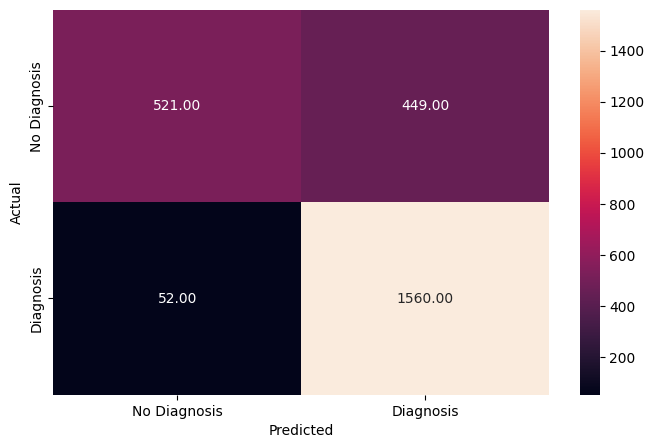

In [ ]:
xgb_model = XGBClassifier(**params, enable_categorical=True)
xgb_model.fit(X_train, y_train)
test_pred = xgb_model.predict(X_test)
metrics_score(y_test, test_pred, ['No Diagnosis','Diagnosis'])

<Axes: xlabel='Importance', ylabel='None'>

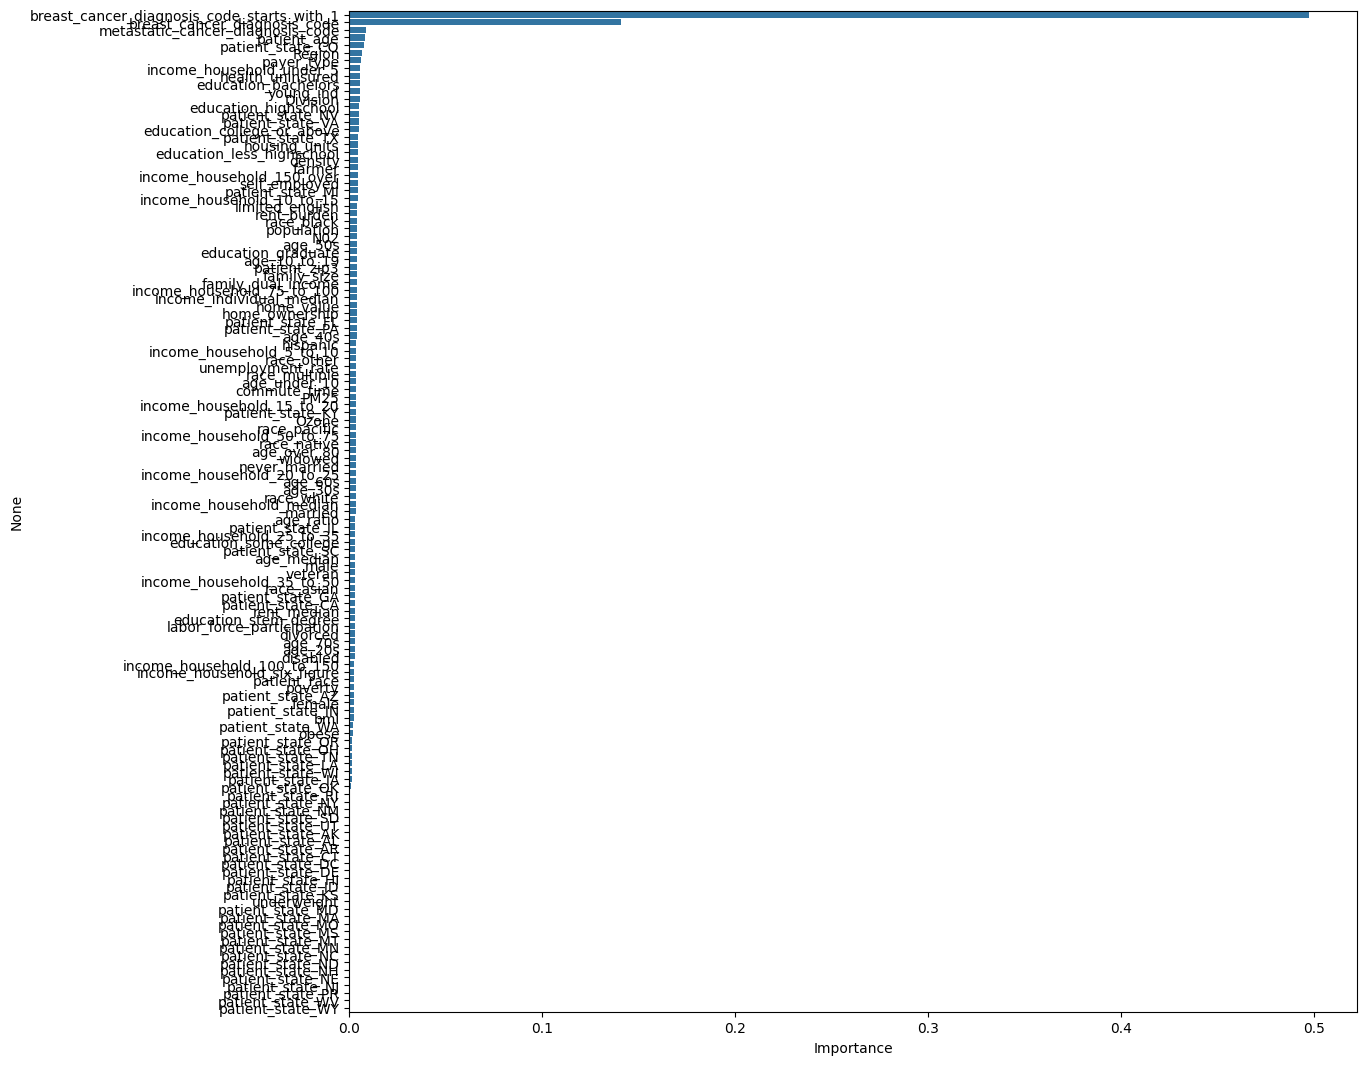

In [ ]:
# Plot the feature importance
importances = xgb_model.feature_importances_
columns = X.columns
importance_df = pd.DataFrame(importances, index = columns,columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
plt.figure(figsize = (13, 13))
sns.barplot(x=importance_df.Importance,y=importance_df.index)

In [ ]:
top_features = importance_df[:20]
top_features

,Importance
breast_cancer_diagnosis_code_starts_with_1,0.497544
breast_cancer_diagnosis_code,0.140700
metastatic_cancer_diagnosis_code,0.008793
patient_age,0.007864
patient_state_CO,0.007672
Region,0.006274
payer_type,0.006080
income_household_under_5,0.005704
health_uninsured,0.005569
education_bachelors,0.005528


### Hyperparameter tuning

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [3, 4, 5],
        'learning_rate' : [0.001, 0.01, 0.02],
        'n_estimators' : [100, 500, 1000]
        }

In [ ]:
xgb_new = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 66)
random_new = RandomizedSearchCV(xgb_new, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=66 )
random_new.fit(X_train, y_train)
print(random_new.best_estimator_)

In [ ]:
test_proba = random_new.predict_proba(X_test)
score_proba = roc_auc_score(y_test, test_proba[:, 1])
print(score_proba)

### Submission

In [ ]:
test_clean[num_col] = scaler.fit_transform(test_clean[num_col])

In [ ]:
sub_proba = random_new.predict_proba(test_clean.drop)
test['DiagPeriodL90D'] = sub_proba[:, 1]
sub = test[['patient_id','DiagPeriodL90D']]
sub.head()

In [ ]:
sub.to_csv('submission.csv', index=False)